## Generate Figure 2, for the sensitivity analysis manuscript
In this notebook we generate the components needed in order to create figure 2 in the sensitivity analysis manuscript. 

In particular, we first generate overall sensitivity values (defined as the Frobenius norm of the hessian matrix), and the individual parameter sensitivity values as given by the magnitude of the components of the principal eigenvector of the hessian. More details for these computations are provided below. 

In [9]:
from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, jit, jacfwd, jacrev
import jax.numpy as jnp

# import the needed modules 
from hessian_normalized import HessianCircadian
from hessian_normalized import Actogram
from hessian_normalized import ParameterRecovery
from lightschedules import RegularLight
from lightschedules import ShiftWorkLight
from lightschedules import ShiftWorkerThreeTwelves
from lightschedules import SocialJetLag
from lightschedules import SlamShift

sens=HessianCircadian()
params = sens.get_parameters_array()

figure_save == 'off'
    
# define the light schedules 
ndays = 7
intensity = 979
dt = 0.1
ts=np.arange(0, 24*ndays, dt)
lights_rl = jnp.array([RegularLight(t, Intensity = intensity) for t in ts ]) # define the light schedules 
lights_sw = jnp.array([ShiftWorkLight(t,Intensity = intensity) for t in ts ])
lights_sw312 = jnp.array([ShiftWorkerThreeTwelves(t,Intensity = intensity) for t in ts ])
lights_sjl = jnp.array([SocialJetLag(t,Intensity = intensity) for t in ts ])
lights_ss = jnp.array([SlamShift(t,Intensity = intensity) for t in ts ])
lights_dark = jnp.zeros([len(ts),])

Having imported the hessian-related modules and defined the six light schedules of interest in the previous cell, we get the stored initial conditions and use these and the light schedules to generate a hessian matrix for each light schedule. 

To define the initial conditions, we assume that the individual light schedules (e.g., regular light, shift work, social jet lag) are repeated in the weeks prior to the week of interest that we study here. Thus, we simulate the light schedule through the model, week by week, repeatedly until the final model state values reach a convergence criteria. See ics_generate.ipynb for more details. 

To generate the hessian matrix, we define a loss function as 
$$L(\lambda) = \frac{1}{N}\sum_{n = 1}^N ((x_n^{(1)} - x_n^{(2)})^2 + (y_n^{(1)} - y_n^{(2)})^2)$$
where $x^{(1)} = R_\theta \cos(\psi_\theta), y^{(1)} = R_\theta \sin(\psi_\theta)$ are model states generated from perturbed parameter values $\theta$, $x^{(1)} = R_{\theta^*} \cos(\psi_{\theta^*}), y^{(1)} = R_{\theta^*} \sin(\psi_{\theta^*})$ are model states generated from default parameter values $\theta^*$, and $\theta = \lambda \theta^*$.

We then compute the hessian matrix of $L$, evaluated at $\lambda = \vec{1}$.

In [10]:
# get stored initial conditions, generated in ics_generate.ipynb
%store -r ics_rl
%store -r ics_sw
%store -r ics_sw312
%store -r ics_sjl
%store -r ics_ss
%store -r ics_dark

# generate the new sensitivity hessian results 
normalized_hessian_rl = sens.normalized_hessian(u0 = ics_rl,light = lights_rl)
normalized_hessian_sw = sens.normalized_hessian(u0 = ics_sw,light = lights_sw)
normalized_hessian_sw312 = sens.normalized_hessian(u0 = ics_sw312,light = lights_sw312)
normalized_hessian_sjl = sens.normalized_hessian(u0 = ics_sjl,light = lights_sjl)
normalized_hessian_ss = sens.normalized_hessian(u0 = ics_ss,light = lights_ss)
normalized_hessian_dark = sens.normalized_hessian(u0 = ics_dark,light = lights_dark)

## Generate overall sensitivity figure
We compute and plot the Frobenius norm of the six hessian matrices for the different light schedules.

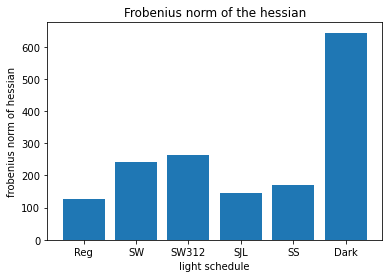

In [11]:
# generate figures for the hessian results--overall sensitivity figure 
norm_2 = np.zeros(6)
norm_2[0] = np.linalg.norm(normalized_hessian_rl)
norm_2[1]  = np.linalg.norm(normalized_hessian_sw)
norm_2[2] = np.linalg.norm(normalized_hessian_sw312)
norm_2[3] = np.linalg.norm(normalized_hessian_sjl)
norm_2[4] = np.linalg.norm(normalized_hessian_ss)
norm_2[5] = np.linalg.norm(normalized_hessian_dark)

# visualize 
plt.bar(np.arange(6),norm_2)
plt.xlabel('light schedule')
plt.ylabel('frobenius norm of hessian')
plt.xticks(np.arange(6), ('Reg', 'SW', 'SW312', 'SJL', 'SS','Dark'))
plt.title('Frobenius norm of the hessian')
if figure_save == 'on':
    plt.savefig('figures_8_29/bar_plot_hessian_week.svg')
plt.show()

We see that the constant darkness schedule generates the largest Frobenius norm of the hessian, by a significant margin. This is followed by the shift work three twelve's schedule, the shift work schedule, the slam shift schedule, the social jet lag schedule, and finally the regular light schedule. 

## Generate individual parameter sensitivity figures 
We now examine the eigenvalues and principal eigenvector for the hessian matrices computed previously. We generate a scatter plot of the eigenvalues, and a bar plot of the magnitude of the components of the principal eigenvector. Additionally, we store the principal eigenvectors for future use in Figure 4, wheen they are compared with the principal eigenvectors from example real activity data schedules.

We also naturally generate plots of the eigenvalues here. These are used to create a supplemental figure. 

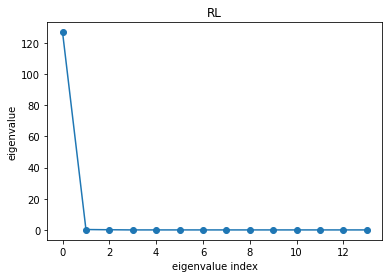

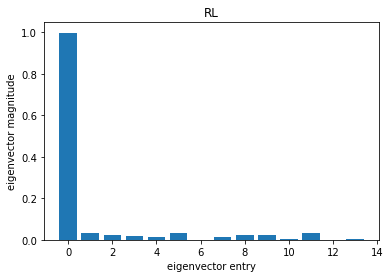

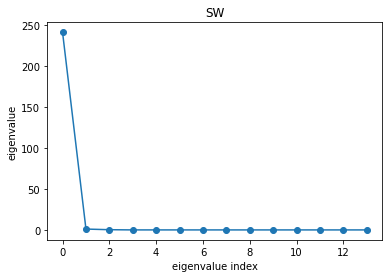

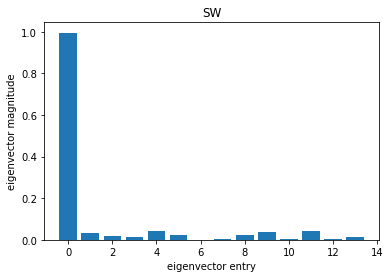

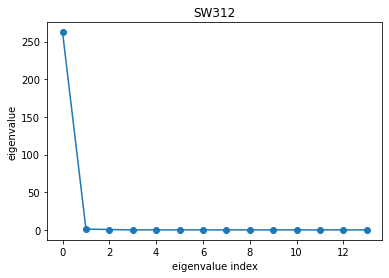

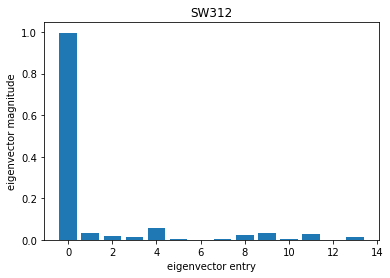

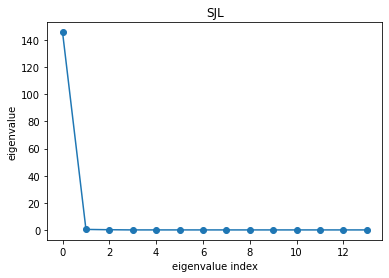

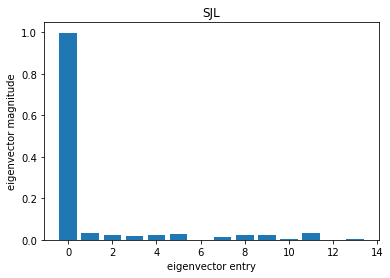

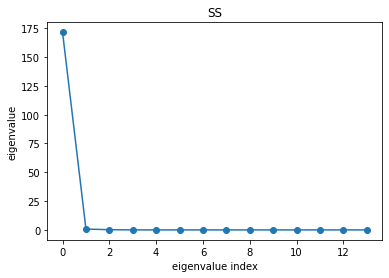

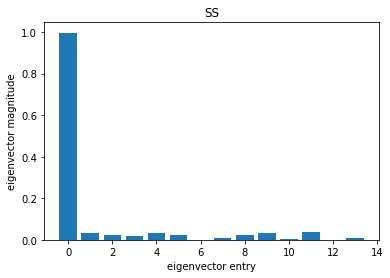

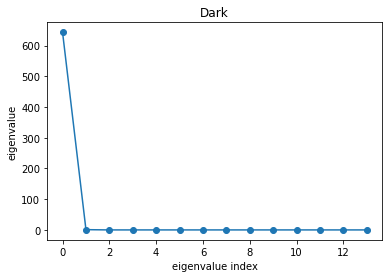

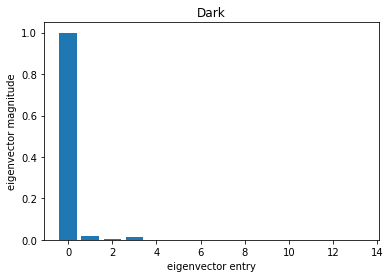

Stored 'evecs_rl' (ndarray)
Stored 'evecs_sw' (ndarray)
Stored 'evecs_sw312' (ndarray)
Stored 'evecs_sjl' (ndarray)
Stored 'evecs_ss' (ndarray)
Stored 'evecs_dark' (ndarray)


In [12]:
# generate individual parameter sensitivities 
def generate_eval_figures(hessian, schedule_name):
    
    evals, evecs = np.linalg.eig(hessian)
    evecs_prin = evecs[:,np.argmax(evals)]
    plt.scatter(range(len(evals)),evals)
    plt.plot(range(len(evals)),evals)
    plt.ylabel('eigenvalue')
    plt.xlabel('eigenvalue index')
    plt.title(schedule_name)
    if figure_save == 'on':
        plt.savefig('figures_8_29/evals_rl.svg')
    plt.show()
    
    plt.bar(range(len(evecs)),abs(evecs_prin))
    plt.title(schedule_name)
    plt.ylabel('eigenvector magnitude')
    plt.xlabel('eigenvector entry')
    plt.title(schedule_name)
    if figure_save == 'on':
        plt.savefig('figures_8_29/unscaled_evec_rl.svg')
    plt.show()
    return evals, evecs_prin

schedule_name = 'RL'
evals_rl, evecs_rl = generate_eval_figures(normalized_hessian_rl, schedule_name)
schedule_name = 'SW'
evals_sw, evecs_sw = generate_eval_figures(normalized_hessian_sw, schedule_name)
schedule_name = 'SW312'
evals_sw312, evecs_sw312 = generate_eval_figures(normalized_hessian_sw312, schedule_name)
schedule_name = 'SJL'
evals_sjl, evecs_sjl = generate_eval_figures(normalized_hessian_sjl, schedule_name)
schedule_name = 'SS'
evals_ss, evecs_ss = generate_eval_figures(normalized_hessian_ss, schedule_name)
schedule_name = 'Dark'
evals_dark, evecs_dark = generate_eval_figures(normalized_hessian_dark, schedule_name)


# store the eigenvectors for future use  
%store evecs_rl
%store evecs_sw
%store evecs_sw312
%store evecs_sjl
%store evecs_ss
%store evecs_dark

We see that the first eigenvalue of the hessian has a large magnitude, while the others are all relatively small. Similarly, the first component of the principal eigenvector has the largest magnitude by far, when compared to the other entries of the eigenvector. 